# Gradient Boosting
 
Using gradient boosting, the critical temperatures of superconductors were predicted. Using the clusters produced by the [clustering](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) notebook, 3 models were created. One only using data from Label 1, one only using the data from Label 2, and one using all labeled data. Unlike with the linear regression models, the gradient boosting results were not improved by separating the data into clusters before fitting. The models RMSE was 11.40 K  without separating and 11.56 K when seperated.

In [4]:
import numpy as np
import pandas as pd

#regular expression
import re

#visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rcParams.update({'font.size': 20})

#machine learn algrothism 
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import xgboost as xgb
#from sklearn.model_selection import cross_val_score

#for statistics
from scipy import stats

#for debugging
import pdb
from importlib import reload

#test time of xgboost
import timeit

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
#from hdbscan import HDBSCAN

#dataframes with was initialized in the Superconductor_statistics notebook
from ipynb.fs.defs.Superconductor_statistics import InitializeDataframes
#clustering algorithm Superconductor_clustering notebook
from ipynb.fs.defs.Superconductor_clustering import KMeanTypeI_II
#Graphing algorithm from Superconductor_linear_reg
from ipynb.fs.defs.Superconductor_linear_reg import TempLinearPlot,LinearPredict

## Initializing data and seperating into clusters.

See [statistics](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_statistics.ipynb) notebook for data wrangling details and [clustering](https://github.com/fullmetalchem15t/superconductors/blob/master/Superconductor_clustering.ipynb) notebook for  clustering details.

In [5]:
#create orignal dataframe
prop_df,atoms_df,material=InitializeDataframes()
prop_df=KMeanTypeI_II(prop_df)

#create bool label I/II database
label1_bool = prop_df['label'] == 1 

#remove label from dataframe. It is not used by linear model
prop_df.drop(['label'],axis=1,inplace=True)

#label 1
prop_label1 = prop_df[label1_bool]
atoms_label1 = atoms_df[label1_bool]
material_label1 = material[label1_bool]

#label 2
prop_label2 = prop_df[~label1_bool]
atoms_label2 = atoms_df[~label1_bool]
material_label2 = material[~label1_bool]

## Property data split into training set and test set
 
Using the properties dataframe, three linear models were created. One from the cluster labeled 1, one from the cluster labeled 2, and the with all labeled data. The data from each model is separated into a training set (to make the model) and a testing set (to test the model), In order to prevent unbalanced data, an equal number of data points from each cluster will be placed into the training set with all labeled data.

In [6]:
#label1
X_label1 = prop_label1.drop(['critical_temp'],axis=1)
y_label1 = prop_label1['critical_temp']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_label1, y_label1, train_size=7000, random_state=42)

#label2
X_label2 = prop_label2.drop(['critical_temp'],axis=1)
y_label2 = prop_label2['critical_temp']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_label2, y_label2, train_size=7000, random_state=42)

#All labels
X_train = pd.concat([X_train1,X_train2])
X_test = pd.concat([X_test1,X_test2])
y_train = pd.concat([y_train1,y_train2])
y_test = pd.concat([y_test1,y_test2])

## Time Test
The time for fittings using xgboost's Scikit-Learn API vs. using xgboost alone was compared. Fitting with xgboost without the Scikit-Learn API is 30 times faster.

In [8]:
print('Time with Scikit-Learn API')
xg_reg = xgb.XGBRegressor(objective="reg:linear",booster='gbtree',n_estimate=1000,learning_rate=0.02)
%timeit xg_reg.fit(X_train,y_train)

print('\nTime without Scikit-Learn API')
dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {"booster":"gblinear", 'objective':'reg:linear','n_estimate':"1000",'learning_rate':0.02}
%timeit xgb.train(dtrain=dmatrix,params = params)

Time with Scikit-Learn API
4.12 s ± 78.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time without Scikit-Learn API
139 ms ± 840 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## xgboost interface function

Adapted from a [script on kaggle](https://www.kaggle.com/tanitter/grid-search-xgboost-with-scikit-learn),
below is a custom functions which interface xgboost with sklearn's Pipeline and GridSearchCV without using the slow Scikit-Learn XGBRegressor API.

In [9]:
class XGBoostRegressor():
    def __init__(self, num_boost_round=10,feature_names=None, **params):
        self.reg = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'reg:linear'})
        self.params.update({'booster':'gbtree'})
        self.params.update({'silent':'1'})
        
        #GridSearchCV does not preserve feature name.
        #Cord harding them causes GridSearchCV to crash. 
        #States 
        self.feature_names = feature_names
    def set_feature_names(feature_names):
        self.feature_names = feature_names
    def fit(self, X, y, num_boost_round=None):
        if self.feature_names is not None:
            dtrain = xgb.DMatrix(X, label=y,feature_names=self.feature_names)
        else:
            dtrain = xgb.DMatrix(data=X, label=y,feature_names=None) 
        if num_boost_round is None: 
            num_boost_round = self.num_boost_round
        self.reg = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
    def predict(self, X):
        dtrain = xgb.DMatrix(X)
        return self.reg.predict(dtrain)    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)
    def get_params(self, deep=True):
        return self.params
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    def get_feature_importance(self,feature_names=None):
        #Create a database of features sorted by index
        feature_dic = self.reg.get_score(importance_type='total_gain')
        feature_df = pd.DataFrame(data=feature_dic.values(),index=feature_dic.keys())
        feature_df.columns = ['Total Gain']
        feature_df.index = feature_df.index.map(lambda x:int(re.sub('f','',x)))
        feature_df.sort_index(inplace=True)
        #rename feature in dataframe to the name features
        if feature_names is not None:
            self.feature_names = feature_names
        if self.feature_names is not None:
            present_features = self.feature_names.tolist()
            for x in range(0,len(self.feature_names)):
                #remove non important features
                if x not in feature_df.index:
                    del present_features[x]
            feature_df.index = present_features
        #Percent Percent Gain column
        Gain_sum = feature_df['Total Gain'].sum()
        feature_df['Percent Gain'] = feature_df['Total Gain'].map(lambda x:x/Gain_sum)
        feature_df.sort_values(['Total Gain'],axis=0,ascending=False,inplace=True)
        return feature_df.head(10).round(2)

In [10]:
#Time for the single calculation in the cv grid search 
scale = StandardScaler()
params = {'n_estimators':1000}
xgboost = XGBoostRegressor(num_boost_round=10,params=params)
param_grid = {'xgboosting__colsample_bytree': [0.25],
             'xgboosting__learning_rate':[0.02]}
pipeline = Pipeline([('scaler',scale),('xgboosting',xgboost)])
grid_xgb = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=4,scoring="r2")
%timeit grid_xgb.fit(X_train,y_train)

1.68 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Gradient Boosting: Tuning Hyperparameters

In the below cells, the hyperparameters of the gradient boosting models are tune to predict the critical temperature of superconductors. [Hamidieh](https://arxiv.org/abs/1803.10260), who work this project is a continuation of, used a more extensive grid to tune their model than here. They tuned the learning rate and number of trees (which we did not) and did not tune the subsample of data (which we did). We found that the learning rate and the number of trees did not have a big effect on root means square error(RMSE) and due to the time restraint on this project, they were not tuned. 
 
Three models were created (and tuned), one using Label 1 only, and one using Label 2 only, and one using all labeled training data.

In [11]:
def XGBFit(X_train, X_test, y_train, y_test,param_grid={}):
    #scaling
    scale = StandardScaler()

    #xgboost
    xgboost = XGBoostRegressor(feature_names=X_train.columns)
    #pineline
    pipeline = Pipeline([('scaler',scale),('xgboosting',xgboost)])

    #default grid
    if not bool(param_grid):
        param_grid = {
                'xgboosting__colsample_bytree': [0.50,0.75,1.0],
                'xgboosting__subsample':[0.50,0.75,1.0],
                'xgboosting__max_depth': [15,16,17,18,19,20,21,22,23,24],
                'xgboosting__min_child_weight':[1,5,10],
                'xgboosting__n_estimators': [750]
            }
    #grid
    grid_xgb = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=4,scoring='r2', verbose=0)
    grid_xgb.fit(X_train,y_train)
    grid_xgb.best_estimator_.named_steps['xgboosting'].num_boost_round

    #accuracy metrics
    r2 = grid_xgb.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test,grid_xgb.predict(X_test)))
    print("Tuned XGBRegressor params: {}".format(grid_xgb.best_params_))
    print("Tuned XGBRegressor R squared: {:.2f}".format(r2))
    print("Tuned XGBRegressor RMSE: {:.2f}\n".format(RMSE))
    return grid_xgb

In [12]:
#All labeled data model params previously determined.The orignal grid used is the default in XGBFit (see above cell)
params = {'xgboosting__colsample_bytree': [0.5],
          'xgboosting__max_depth': [20], 
          'xgboosting__min_child_weight': [5], 
          'xgboosting__n_estimators': [750], 
          'xgboosting__subsample': [1.0]
         }
grid_xgb = XGBFit(X_train, X_test, y_train, y_test,param_grid=params)

#label 1 model params previously determined. The orignal grid used is the default in XGBFit (see above cell)
params1 = {'xgboosting__colsample_bytree': [0.75],
          'xgboosting__max_depth': [16],
          'xgboosting__min_child_weight': [5],
          'xgboosting__n_estimators': [750], 
          'xgboosting__subsample': [1.0]
         }
grid_xgb1 = XGBFit(X_train1, X_test1, y_train1, y_test1,param_grid=params1)

#label 2 model params previously determined. The orignal grid used is the default in XGBFit (see above cell)
params2 = {'xgboosting__colsample_bytree': [0.5],
         'xgboosting__max_depth': [21], 
         'xgboosting__min_child_weight': [10],
         'xgboosting__n_estimators': [750],
         'xgboosting__subsample': [1.0]
        }
grid_xgb2 = XGBFit(X_train2, X_test2, y_train2, y_test2,param_grid=params2)

Tuned XGBRegressor params: {'xgboosting__colsample_bytree': 0.5, 'xgboosting__max_depth': 20, 'xgboosting__min_child_weight': 5, 'xgboosting__n_estimators': 750, 'xgboosting__subsample': 1.0}
Tuned XGBRegressor R squared: 0.90
Tuned XGBRegressor RMSE: 11.40

Tuned XGBRegressor params: {'xgboosting__colsample_bytree': 0.75, 'xgboosting__max_depth': 16, 'xgboosting__min_child_weight': 5, 'xgboosting__n_estimators': 750, 'xgboosting__subsample': 1.0}
Tuned XGBRegressor R squared: 0.84
Tuned XGBRegressor RMSE: 3.43

Tuned XGBRegressor params: {'xgboosting__colsample_bytree': 0.5, 'xgboosting__max_depth': 21, 'xgboosting__min_child_weight': 10, 'xgboosting__n_estimators': 750, 'xgboosting__subsample': 1.0}
Tuned XGBRegressor R squared: 0.85
Tuned XGBRegressor RMSE: 13.18



## Get Predicted Values and RMSE Error

The RMSE using all three models is shown below. The prediction of gradient boosting model fitted using all labeled had an RMSE of 11.40 K. When the clustered labeled data was separated into different gradient boosting model, the RMSE was 11.56 K. Separating the labeled data by clusters was therefore not found to improve model accuracy when fitting with gradient boosting.

In [13]:
#get predicted from regression on entire model 
y_pred,RMSE=LinearPredict(X_test,y_test,grid_xgb)
y_pred_data1,RMSE_label1=LinearPredict(X_test1,y_test1,grid_xgb)
y_pred_data2,RMSE_label2=LinearPredict(X_test2,y_test2,grid_xgb)

#get predicted from regression on seperated labeled data
y_pred_model1,RMSE_model1=LinearPredict(X_test1,y_test1,grid_xgb1)
y_pred_model2,RMSE_model2=LinearPredict(X_test2,y_test2,grid_xgb2)

#combine the predicted from the two seperated label models 
y_pred_seperated = np.concatenate((y_pred_model1,y_pred_model2))
RMSE_seperated = np.sqrt(mean_squared_error(y_test,y_pred_seperated))

In [14]:
print('RMSE from All labeled modeled together')
print('Label One: {:.2f} K'.format(RMSE_label1))
print('Label Two: {:.2f} K'.format(RMSE_label2))
print('All data:{:.2f} K'.format(RMSE))

print('\nRMSE from labeled clusters are modeled seperately')
print('Label One: {:.2f} K'.format(RMSE_model1))
print('Label Two: {:.2f} K'.format(RMSE_model2))
print('All Data: {:.2f} K'.format(RMSE_seperated))

RMSE from All labeled modeled together
Label One: 3.57 K
Label Two: 12.97 K
All data:11.40 K

RMSE from labeled clusters are modeled seperately
Label One: 3.43 K
Label Two: 13.18 K
All Data: 11.56 K


## Important Features

The features with the largest gains are below. The percent gain was determined by totals of a feature divided by the total gains of all features. It is assumed that the larger the gain, the more important that feature is for critical temperature prediction.

In [15]:
#Get Important features for All labeled data
df_all = grid_xgb.best_estimator_.named_steps['xgboosting'].get_feature_importance(X_train.columns)[['Percent Gain']]
df_all.reset_index(level=0, inplace=True)
df_all.rename(columns={'index':'Feature'},inplace=True)
df_all['Label'] = 'All label'
df_all['Rank'] = range(1,11,1)

#Get Important features for model 1
df1 = grid_xgb1.best_estimator_.named_steps['xgboosting'].get_feature_importance(X_train.columns)[['Percent Gain']]
df1.reset_index(level=0, inplace=True)
df1.rename(columns={'index':'Feature'},inplace=True)
df1['Label'] = 'label 1'
df1['Rank'] = range(1,11,1)

#Get Important features for model 2
df2 = grid_xgb2.best_estimator_.named_steps['xgboosting'].get_feature_importance(X_train.columns)[['Percent Gain']]
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index':'Feature'},inplace=True)
df2['Label'] = 'label 2'
df2['Rank'] = range(1,11,1)

#combine into one table
df_merged = pd.concat([df_all,df1,df2])
df_merged = df_merged.pivot(index='Rank',columns='Label').swaplevel(i=0, j=1, axis=1)

#reorganizing 
df_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='All label']
df1_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='label 1']
df2_multilevel = df_merged.iloc[:,df_merged.columns.get_level_values(0)=='label 2']
pd.concat([df_multilevel,df1_multilevel,df2_multilevel],axis=1)

Label                        All label               \
                               Feature Percent Gain   
Rank                                                  
1            range_ThermalConductivity         0.39   
2          wtd_std_ThermalConductivity         0.14   
3                  wtd_entropy_Valence         0.08   
4         wtd_mean_ThermalConductivity         0.06   
5                     wtd_mean_Valence         0.03   
6                  range_atomic_radius         0.03   
7                        gmean_Density         0.02   
8      wtd_entropy_ThermalConductivity         0.02   
9             wtd_std_ElectronAffinity         0.02   
10                   wtd_gmean_Valence         0.01   

Label                          label 1               \
                               Feature Percent Gain   
Rank                                                  
1                wtd_gmean_atomic_mass         0.20   
2                            range_fie         0.09   
3      wtd_entropy_ThermalConductivity         0.07   
4                         mean_Density         0.05   
5                 wtd_mean_atomic_mass         0.04   
6                  entropy_atomic_mass         0.04   
7                     wtd_mean_Valence         0.04   
8            wtd_entropy_atomic_radius         0.04   
9           wtd_gmean_ElectronAffinity         0.03   
10                            mean_fie         0.03   

Label                          label 2               
                               Feature Percent Gain  
Rank                                                 
1         wtd_mean_ThermalConductivity         0.24  
2        wtd_range_ThermalConductivity         0.12  
3          wtd_std_ThermalConductivity         0.07  
4               gmean_ElectronAffinity         0.06  
5                     wtd_mean_Valence         0.05  
6                  range_atomic_radius         0.04  
7                      std_atomic_mass         0.04  
8                 std_ElectronAffinity         0.03  
9      wtd_entropy_ThermalConductivity         0.03  
10                         std_Density         0.03

## Gradient Boosting Predicted vs. Reported Critical Temperature Scatterplots

[]

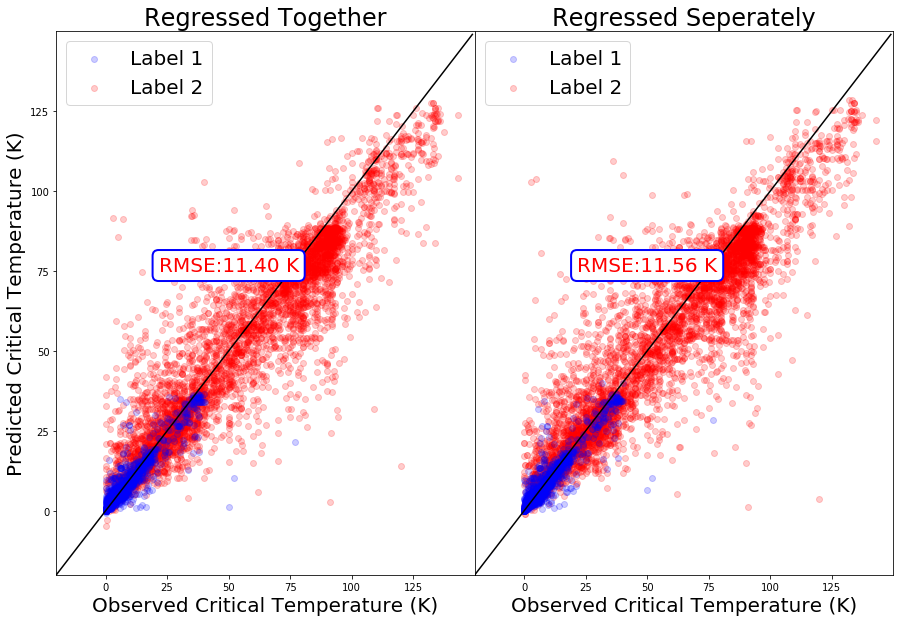

In [26]:
fig = plt.figure(figsize=(15,10)) 
grid = gridspec.GridSpec(1, 2)
grid.update(wspace=0.00, hspace=0.05)
ax1 = plt.subplot(grid[0])
TempLinearPlot(y_pred_data1, y_test1,y_pred_data2,y_test2,ax1,'Regressed Together',True,xlim=[-20,150],ylim=[-20,150])
plt.subplots_adjust(wspace=None, hspace=None)
ax2 = plt.subplot(grid[1])
#ax2 = fig.add_subplot(1,2,2)
TempLinearPlot(y_pred_model1, y_test1,y_pred_model2,y_test2,ax2,'Regressed Seperately',False,xlim=[-20,150],ylim=[-20,150])
plt.savefig('images/gbx_plot.jpg',bbox_inches='tight')
plt.plot()